In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error
import pickle
from prepare_data import PrepareData

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\training\prepare_data.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("6H")


In [2]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

Fill the missing value with the previous data from the role.

In [3]:
train_data.columns

Index(['id', 'light', 'temperature', 'soil_moisture', 'humidity', 'api_temp',
       'precipitation', 'cloud_cover'],
      dtype='object')

In [4]:
for column in train_data.columns:
    print(column)
    if column == 'id':
        continue
    train_data[column] = train_data[column].ffill()
    test_data[column] = test_data[column].ffill()

id
light
temperature
soil_moisture
humidity
api_temp
precipitation
cloud_cover


C:\Users\krist\AppData\Local\Temp\ipykernel_17636\2442158754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].ffill()
C:\Users\krist\AppData\Local\Temp\ipykernel_17636\2442158754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[column] = test_data[column].ffill()


# EDA

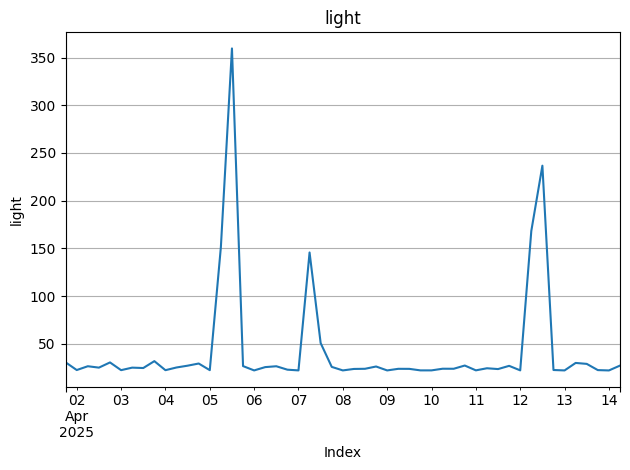

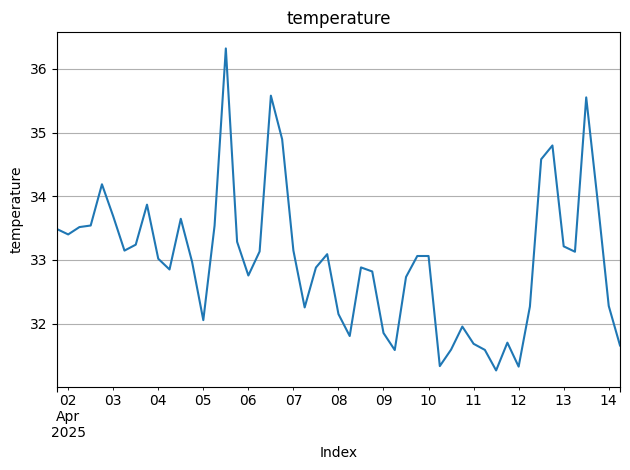

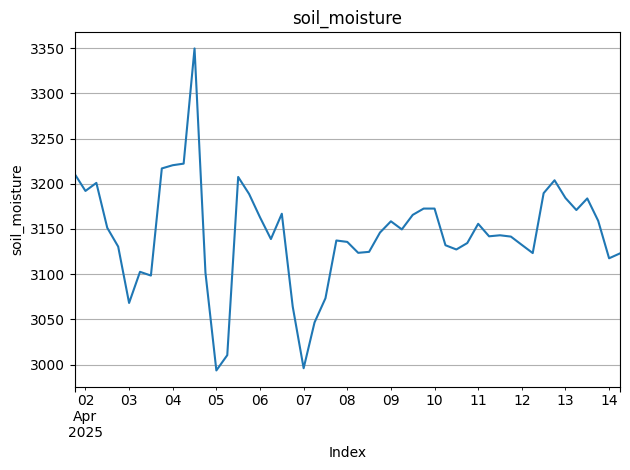

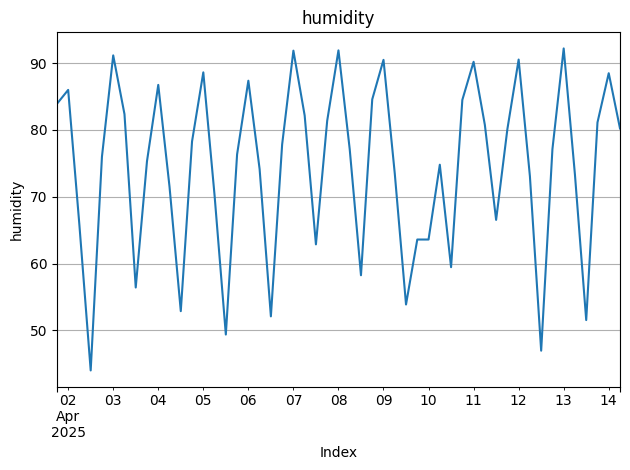

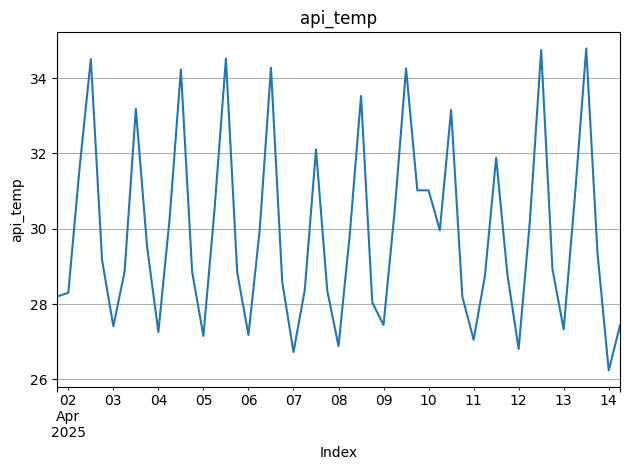

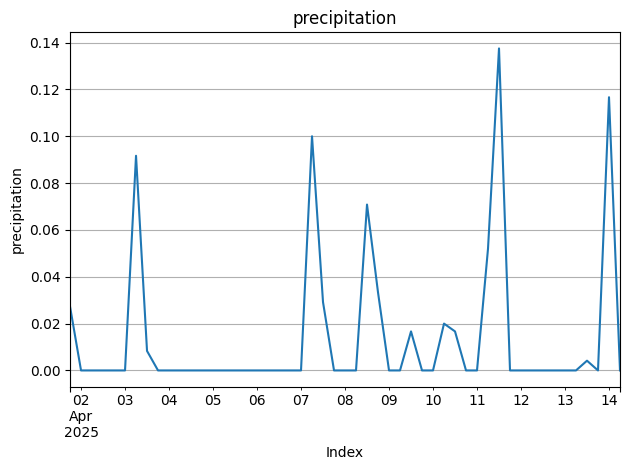

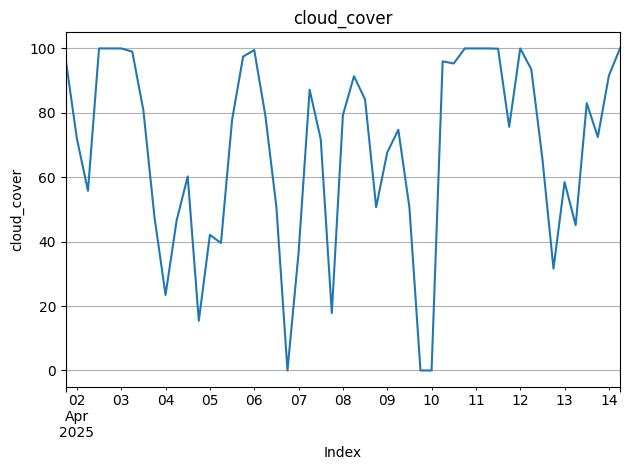

In [5]:
for column in df.columns:
    if column == "id":
        continue
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

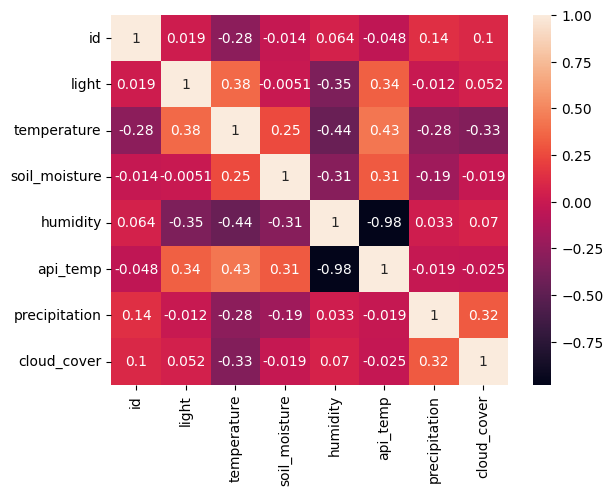

In [6]:
sns.heatmap(df.corr(),annot=True)

## Find D parameter

We'll use adfuller test.

In [7]:
data = df["soil_moisture"].dropna()
diff = 0
while True:
    result = adfuller(data)
    if result[1] < 0.05 or result[0] < result[4]["5%"]:
        print(f"d={diff}")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')
        break
    data = data.diff().dropna()
    diff+=1

d=0
ADF Statistic: -3.8661330129193714
p-value: 0.0022987201524489625
Critial Values:
   1%, -3.610399601308181
Critial Values:
   5%, -2.939108945868946
Critial Values:
   10%, -2.6080629651545038


Therefore, d=0.

In [8]:
print(f"The diff value is {diff}")

The diff value is 0


## Find P parameter

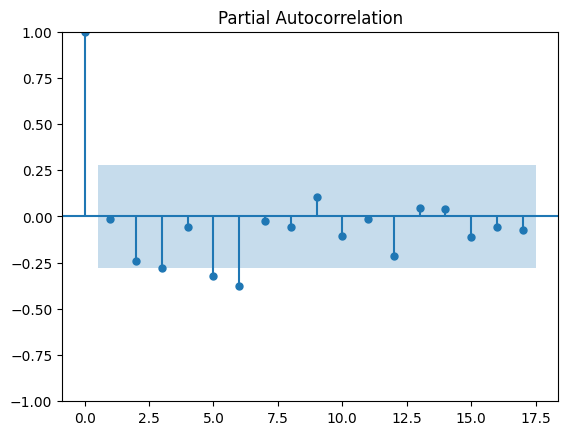

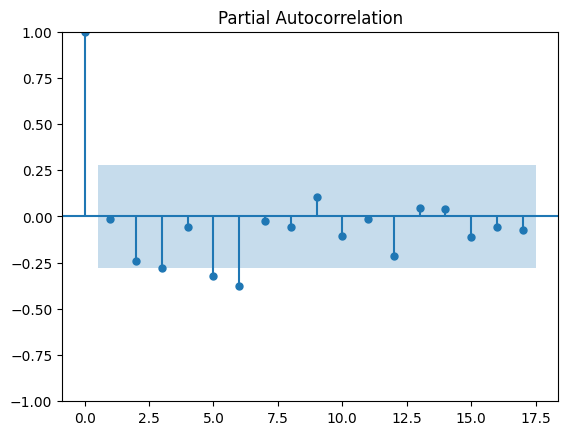

In [9]:
plot_pacf(df["soil_moisture"].diff().dropna())


There are 1 exceptionally high bars, therefore, p=1

## Find Q parameter

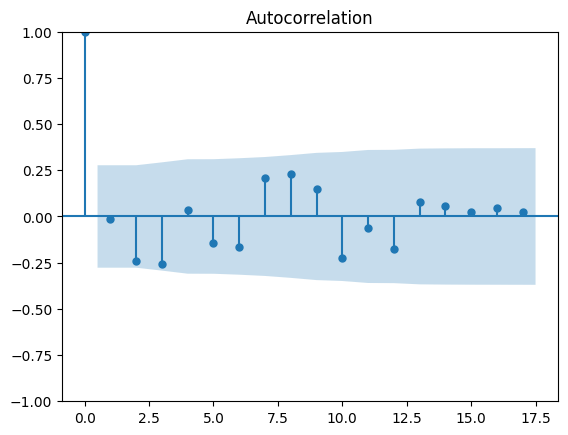

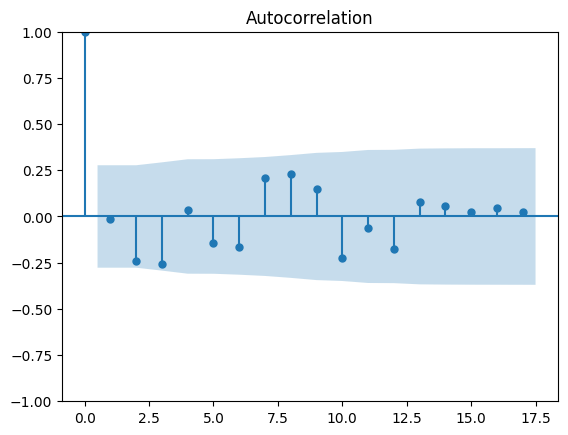

In [10]:
plot_acf(df["soil_moisture"].diff().dropna())

There are 1 exceptionally high bars, therefore, q=1

# Pre-Processing

Already replaced missing value with ffill

In [11]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 18:00:00,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02 00:00:00,13.0,22.453833,33.401067,3192.000000,86.000000,28.300000,0.000000,72.000000
2025-04-02 06:00:00,23.5,26.436983,33.516494,3200.916667,65.722222,31.611111,0.000000,55.777778
2025-04-02 12:00:00,44.5,24.979783,33.541017,3151.187500,44.000000,34.504167,0.000000,100.000000
2025-04-02 18:00:00,68.5,30.427021,34.188162,3130.416667,76.000000,29.166667,0.000000,100.000000


In [12]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09 00:00:00,662.5,22.044396,31.854167,3158.416667,90.500,27.445833,0.000000,67.666667
2025-04-09 06:00:00,686.5,23.729654,31.586587,3149.458333,73.500,30.525000,0.000000,74.750000
2025-04-09 12:00:00,710.5,23.680588,32.733071,3165.520833,53.875,34.258333,0.016667,50.666667
2025-04-09 18:00:00,725.0,22.092880,33.062520,3172.500000,63.600,31.020000,0.000000,0.000000
2025-04-10 00:00:00,NaN,22.092880,33.062520,3172.500000,63.600,31.020000,0.000000,0.000000


# Train the model

Import the model to predict the exog values

In [16]:
exog_columns = ['humidity', 'api_temp']

In [17]:
exog_models = []
for column in exog_columns:
    with open(f'../exports/{column}_sarima.pkl', 'rb') as file:
        exog_models.append(pickle.load(file))

In [18]:
forecast_steps = len(test_data)
exog_predictions = (
    exog_models[0].get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename(exog_columns[0])
    .to_frame()
)

for model_index in range(len(exog_models)-1):
    new_prediction = (
        exog_models[model_index+1].get_forecast(steps=forecast_steps)
        .predicted_mean
        .rename(exog_columns[model_index+1])
        .to_frame()
    )
    exog_predictions = pd.concat(
        [exog_predictions, new_prediction], 
        axis=1
    )
    
exog_predictions.head()

,humidity,api_temp
2025-04-09 00:00:00,93.453321,26.546333
2025-04-09 06:00:00,78.908834,29.840508
2025-04-09 12:00:00,59.924181,33.411610
2025-04-09 18:00:00,83.044317,28.083578
2025-04-10 00:00:00,92.556241,26.630572


In [19]:
print("Training exog stats:")
print(train_data[exog_columns].describe())

print("\nPrediction exog stats:")
print(exog_predictions.describe())

Training exog stats:
        humidity   api_temp
count  29.000000  29.000000
mean   74.362152  29.872509
std    13.743819   2.530750
min    44.000000  26.725000
25%    65.722222  28.200000
50%    77.125000  28.858333
75%    84.583333  31.611111
max    91.916667  34.520833

Prediction exog stats:
        humidity   api_temp
count   9.000000   9.000000
mean   80.106848  29.164668
std    13.064358   2.683114
min    59.073390  26.546333
25%    77.956817  26.712352
50%    83.044317  28.124228
75%    92.556241  29.840508
max    93.453321  33.411610


## Actual Prediction

In [20]:
model = SARIMAX(
    endog=train_data['soil_moisture'],
    exog=train_data[exog_columns],
    order=(1,0,1)
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                   29
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -161.993
Date:                Wed, 30 Apr 2025   AIC                            333.987
Time:                        16:36:16   BIC                            340.823
Sample:                    04-01-2025   HQIC                           336.128
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      12.3998      0.611     20.304      0.000      11.203      13.597
api_temp      74.2466      1.719     43.190      0.000      70.877      77.616
ar.L1          0.3030      0.347      0.874      0.382      -0.376       0.982
ma.L1          0.3184      0.358      0.888      0.374      -0.384       1.021
sigma2      4108.1187   1484.741      2.767      0.006    1198.079    7018.158
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.85   Prob(JB):                         0.67
Heteroskedasticity (H):               0.86   Skew:                             0.10
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
steps = int(test_data['soil_moisture'].count())
prediction = results.get_forecast(steps=steps , exog=exog_predictions[exog_columns].iloc[:steps]).predicted_mean
prediction.columns = ['predicted']
prediction

2025-04-09 00:00:00    3153.602670
2025-04-09 06:00:00    3201.228911
2025-04-09 12:00:00    3225.933398
2025-04-09 18:00:00    3115.505075
2025-04-10 00:00:00    3125.108095
2025-04-10 06:00:00    3181.591991
2025-04-10 12:00:00    3205.031257
2025-04-10 18:00:00    3122.388797
2025-04-11 00:00:00    3131.963079
Freq: 6h, Name: predicted_mean, dtype: float64

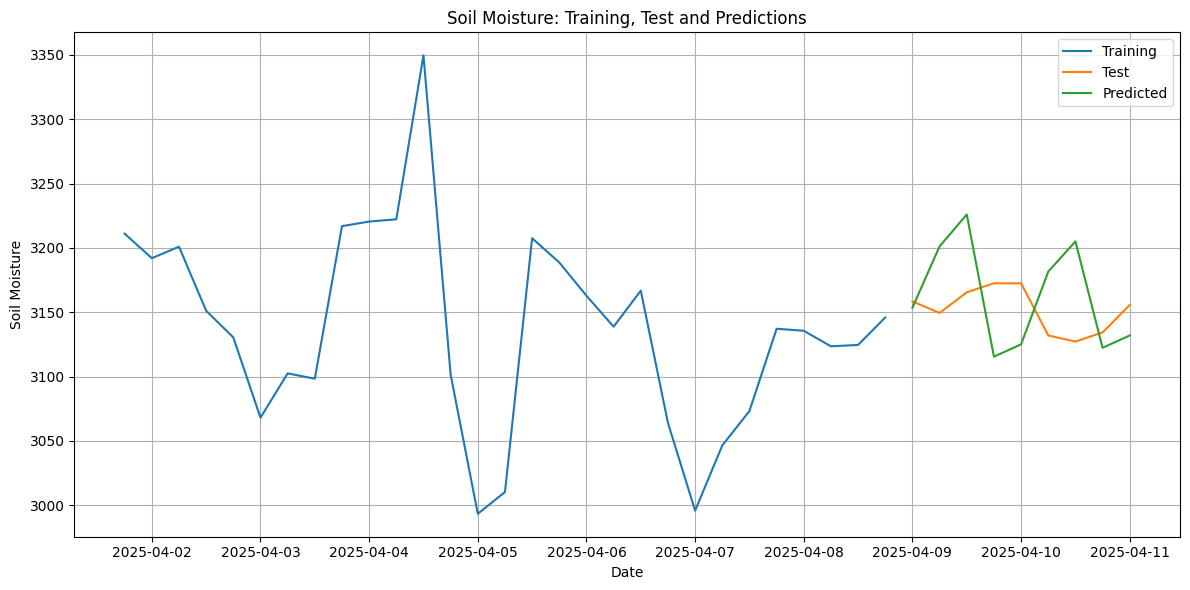

RMSE :  48.380153873840975


In [22]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


## Exporting the trained model with Pickle for external uses.

**Warning** : Do not unpickle untrusted model because it might execute a malicious code hidden in the model file.

In [23]:
with open('../exports/plant_water.pkl', 'wb') as file:
    pickle.dump(results, file)